In [1]:
# Install the pycoco library as it is not part of the Kaggle environment
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-l6mpo4ld
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-l6mpo4ld
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272561 sha256=189ea961e77fff147c05a09c0a2ba6f7d95170dc2ceff49f5f099e1d99a009d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-36iq5fyw/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from pycocotools.coco import COCO

### TO DO:
https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047

Link to website on guide to read the images with their annotations using the coco indexer ('train_coco'). Implement a function to preview images with their annotations.

In [3]:
# Define the image dataset and annotations paths
val_images_path = '../input/food-recognition-challenge/val-v0.4/val/images/'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

In [4]:
# Function to load JSON into a COCO api
def loadAnn(path):
    # Initialize the COCO api for instance annotations
    coco = COCO(path)
    
    # Load the categories in a variable
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print number of categories
    nms = [cat['name'] for cat in cats]
    print('\nNumber of COCO categories: {}\n'.format(len(nms)))
    
    # Print number of instances of each category
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        print('Number of {} instances: {}'.format(nms[i], len(imgIds)))
        
    return coco

In [5]:
# Load annotations and print metadata of the image set
coco = loadAnn(val_anns_path)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!

Number of COCO categories: 273

Number of water instances: 98
Number of pear instances: 6
Number of egg instances: 30
Number of grapes instances: 3
Number of butter instances: 47
Number of bread-white instances: 65
Number of jam instances: 25
Number of bread-whole-wheat instances: 6
Number of apple instances: 38
Number of tea-green instances: 4
Number of white-coffee-with-caffeine instances: 14
Number of tea-black instances: 3
Number of mixed-salad-chopped-without-sauce instances: 28
Number of cheese instances: 22
Number of tomato-sauce instances: 14
Number of pasta-spaghetti instances: 9
Number of carrot instances: 39
Number of onion instances: 9
Number of beef-cut-into-stripes-only-meat instances: 5
Number of rice-noodles-vermicelli instances: 2
Number of salad-leaf-salad-green instances: 64
Number of bread-grain instances: 7
Number of espresso-with-caffeine instances: 16
Number of banana instances: 2

In [6]:
# Function to get image and category Ids of images by a given category
def filterIds(classes):
    catIds = coco.getCatIds(catNms=classes)
    imgIds = coco.getImgIds(catIds=catIds)
    print('Number of images containing given categories: {}'.format(len(imgIds)))
    
    return imgIds, catIds

In [7]:
# Filter and get image and category Ids of images by a sample category
categories = ['bread', 'butter', 'honey']
imgIds, catIds = filterIds(categories)

Number of images containing given categories: 1


In [8]:
# Function to load and display a sample image with and without segmentation
def showImg(ID, path):
    plt.figure(figsize=(10, 10))
    
    img = coco.loadImgs(ID)[0]
    I = cv2.imread(path + '/' + img['file_name'])
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(I)
    ax1.axis('off')
    ax1.title.set_text('Original Sample Image')
    
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(I)
    ax2.axis('off')
    ax2.title.set_text('Segmented Sample Image')
    
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
    
    plt.show()

Sample image of ID: 89255


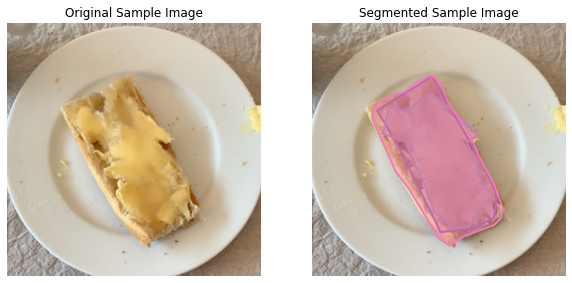

In [9]:
# Display an original and a segmented sample image
ID = imgIds[np.random.randint(0, len(imgIds))]
print('Sample image of ID: {}'.format(ID))
showImg(ID, val_images_path)